# Value-at-risk calculations

_Do not use this code to guide actual investment decisions!_

## Basic setup

In [43]:
import pyspark
from pyspark.context import SparkContext
from pyspark.sql import SparkSession, SQLContext

spark = SparkSession.builder.getOrCreate()

## Loading the data

In [44]:
df = spark.read.load("/data/wikieod.parquet").repartition(8).cache()

## Calculating historical returns

We'll use Spark's windowing functions over data frames to determine the percentage change in each security's price from the previous close to each day's close.

In [45]:
from pyspark.sql import Window
from pyspark.sql.functions import lag, col, avg, variance

ddf = df.select("ticker", "date", "close").withColumn("change", (col("close") / lag("close", 1).over(Window.partitionBy("ticker").orderBy(df["date"])) - 1.0) * 100)
ddf.show(10)

+------+----------+-----+------------------+
|ticker|      date|close|            change|
+------+----------+-----+------------------+
|  ACFN|1992-02-11|10.12|              null|
|  ACFN|1992-02-12|10.75| 6.225296442687744|
|  ACFN|1992-02-13| 10.0|-6.976744186046513|
|  ACFN|1992-02-14|10.12| 1.200000000000001|
|  ACFN|1992-02-18|10.25|1.2845849802371578|
|  ACFN|1992-02-19|10.38|1.2682926829268304|
|  ACFN|1992-02-20| 12.0|15.606936416184958|
|  ACFN|1992-02-21|13.12| 9.333333333333327|
|  ACFN|1992-02-24| 12.0|-8.536585365853655|
|  ACFN|1992-02-25|12.38| 3.166666666666673|
+------+----------+-----+------------------+
only showing top 10 rows



## Characterizing expected return distributions

In [17]:
from pyspark.sql.functions import sqrt
mv = ddf.groupBy("ticker").agg(avg("change").alias("mean"), sqrt(variance("change")).alias("stddev"))
mv.show(10)

+------+--------------------+------------------+
|ticker|                mean|            stddev|
+------+--------------------+------------------+
|  ACFN| 0.06242424778074286| 5.014939329411184|
|  ALXN| 0.15393095850020602| 4.532013447331393|
|  AWAY| 0.02539756867869776|  2.69393746555018|
|   CCK| 0.04952646560952892| 2.931715455254924|
|   CRS|0.031102171093862575| 2.499932187771903|
|  CYNI|-0.03118042941995...|4.1279080205519225|
|   GIS|0.019429696808146178| 1.721249863186511|
|  HBNC|0.027071069371644215|2.0340790030584697|
|  HWAY| 0.08017011008855986| 3.668783283957359|
|     K|0.026071743393784257|1.8036206811619875|
+------+--------------------+------------------+
only showing top 10 rows



Since there are only about 3,000 ticker symbols in our data set, we can easily collect these in driver memory for use in our simulation:

In [18]:
dist_map = mv.rdd.map(lambda r: (r[0], (r[1], r[2]))).collectAsMap()
dist_map["RHT"]

(0.08187986469765945, 3.8769620645490304)

## Getting current security prices

In [19]:
from pyspark.sql.functions import first
priceDF = ddf.orderBy("date", ascending=False).groupBy("ticker").agg(first("close").alias("price"), first("date").alias("date")).cache()
priceDF.show(10)

prices = priceDF.rdd.map(lambda r: (r[0], r[1])).collectAsMap()

+------+-----+----------+
|ticker|price|      date|
+------+-----+----------+
|  ACFN| 0.26|2015-07-23|
|  ALXN|129.0|2016-11-04|
|  AWAY|35.77|2015-12-14|
|   CCK|53.04|2016-11-04|
|   CRS|31.75|2016-11-04|
|  CYNI|  5.7|2015-07-31|
|   GIS|60.65|2016-11-04|
|  HBNC|27.59|2016-11-04|
|  HWAY|19.45|2016-11-04|
|     K|73.67|2016-11-04|
+------+-----+----------+
only showing top 10 rows



## Setting up a simulation

### Generating a random portfolio

In [20]:
from random import randint, seed

def random_portfolio(symbols):
    result = {}
    for s in symbols:
        result[s] = prices[s] * (randint(1, 1000) * 11)
    return result

def portfolio_value(pf):
    return sum([v for v in pf.values()])

seed(0xdea110c8)

portfolio = random_portfolio(ddf.select("ticker").distinct().sample(True, 0.01, 0xdea110c8).rdd.map(lambda r: r[0]).collect())

### Generating random seeds for each simulation

In [21]:
def seeds(count):
    return [randint(0, 1 << 32 - 1) for i in range(count)]

### Defining the simulation

In [22]:
def simstep(pf, params, prng):
    def daily_return(sym):
        mean, stddev = params[sym]
        change = (prng.normalvariate(mean, stddev) + 100) / 100.0
        return change
    return dict([(s, daily_return(s) * v) for s, v in pf.items()])

def simulate(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    
    for day in range(days):
        pf = simstep(pf, params, prng)
    return pf

### Simulating five days of market activity

In [23]:
days_to_simulate = 5
simulation_count = 10000

sc = spark.sparkContext
seed_rdd = sc.parallelize(seeds(simulation_count))
bparams = sc.broadcast(dist_map)
bpf = sc.broadcast(portfolio)
initial_value = portfolio_value(portfolio)

results = seed_rdd.map(lambda s: portfolio_value(simulate(s, bpf.value, bparams.value, days_to_simulate)) - initial_value)

In [24]:
simulated_results = list(zip(results.collect(), seed_rdd.collect()))
simulated_values = [v for (v, _) in simulated_results]
simulated_values.sort()

/opt/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


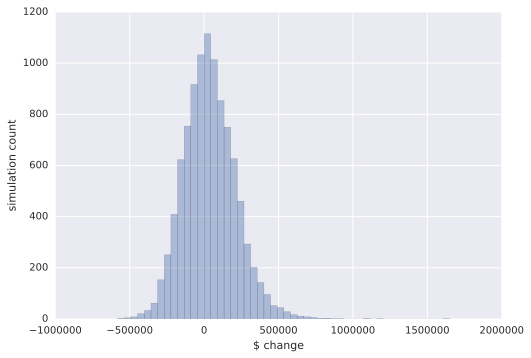

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
import numpy as np
sns.set(color_codes=True)

_ = sns.distplot(simulated_values, kde=False).set(xlabel="$ change", ylabel="simulation count")


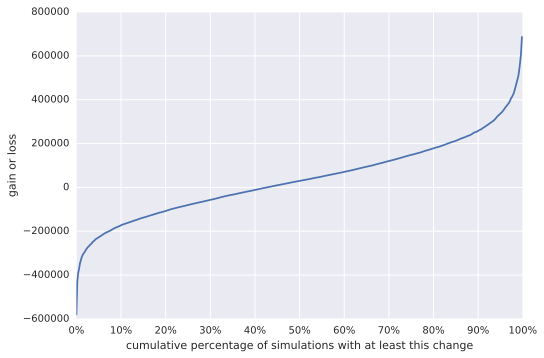

In [26]:
# plot only every 20th simulation result (unless that would leave us with fewer 
# than 50 elements) to avoid generating a huge figure
plotevery = len(simulated_values) > 1000 and 20 or 1

xvals = [float(i) / len(simulated_values) for i in range(len(simulated_values))]
ax = sns.tsplot(np.array(simulated_values[::plotevery]), np.array(xvals[::plotevery]))

# add ticks for every ten percent
ax.get_xaxis().set_ticks([i * 0.1 for i in range(11)])
_ = ax.get_xaxis().set_ticklabels(["%d%%" % (i * 10) for i in range(11)])

_ = ax.set(xlabel="cumulative percentage of simulations with at least this change", ylabel="gain or loss")

### Identifying the 5% value-at-risk

In [27]:
percentage_var = 0.05

simulated_values[int(len(simulated_values) * percentage_var)]

-227027.49157421105

## Visualizing random walks by retaining history

In [28]:
def simulate_with_history(seed, pf, params, days):
    from random import Random
    prng = Random()
    prng.seed(seed)
    pf = pf.copy()
    values = [portfolio_value(pf)]
    
    for day in range(days):
        pf = simstep(pf, params, prng)
        values.append(portfolio_value(pf))
    return values

### Collecting results at each decile

In [29]:
simulated_results.sort()

eleven_results = [simulated_results[int((len(simulated_results) - 1) * i / 10)] for i in range(11)]
eleven_seeds = sc.parallelize([seed for (_, seed) in eleven_results])
walks = eleven_seeds.map(lambda s: simulate_with_history(s, bpf.value, bparams.value, 5))

walk_results = walks.collect()

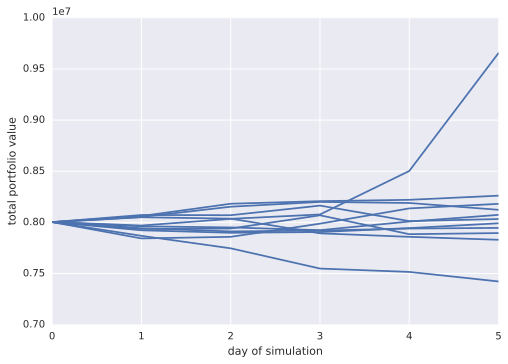

In [30]:
for c in walk_results:
    ax = sns.tsplot(c)

_ = ax.set(xlabel="day of simulation", ylabel="total portfolio value")

# Getting more realistic results

Of course, most real-world stock returns aren't normally distributed.  To make a more interesting simulation, we can try to find a distribution that better models the returns we've observed.  We'll start by looking at the actual distributions of returns.

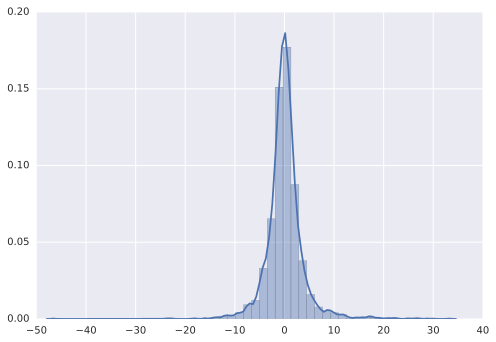

In [31]:
rdist = ddf.filter(ddf["ticker"] == "RHT").select("change").rdd.map(lambda r: r["change"]).filter(lambda c: c is not None).collect()
sns.distplot(rdist)

## Stock price changes aren't normally-distributed

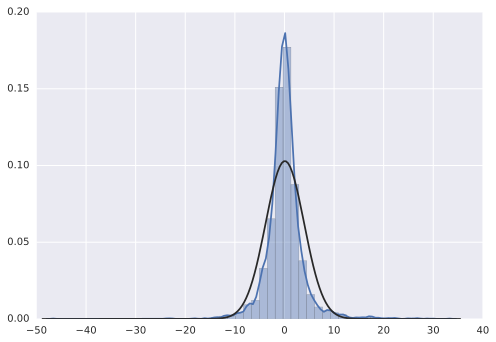

In [32]:
from scipy import stats
sns.distplot(rdist, fit=stats.norm)

## Trying different distributions

In [40]:
symbols = ddf.select("ticker").distinct().sample(True, 0.004).rdd.map(lambda l: l["ticker"]).collect()
dfs = ddf.filter(ddf["ticker"].isin(symbols)).select("ticker", "change").dropna()
sampled_returns = dfs.toPandas()

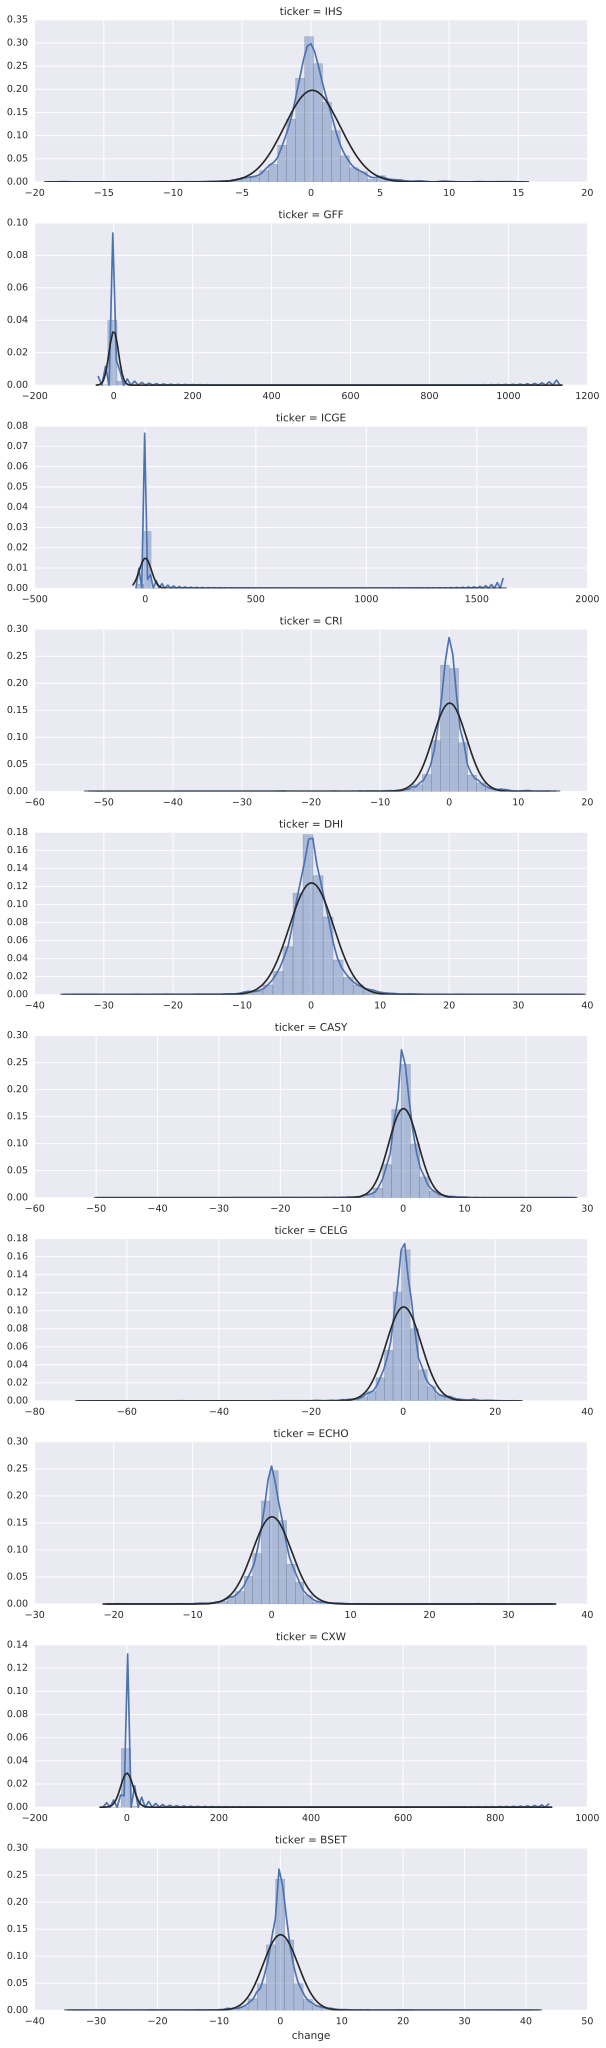

In [41]:
g = sns.FacetGrid(sampled_returns, row="ticker", sharex=False, sharey=False, aspect=3)
_ = g.map(sns.distplot, "change", fit=stats.norm)

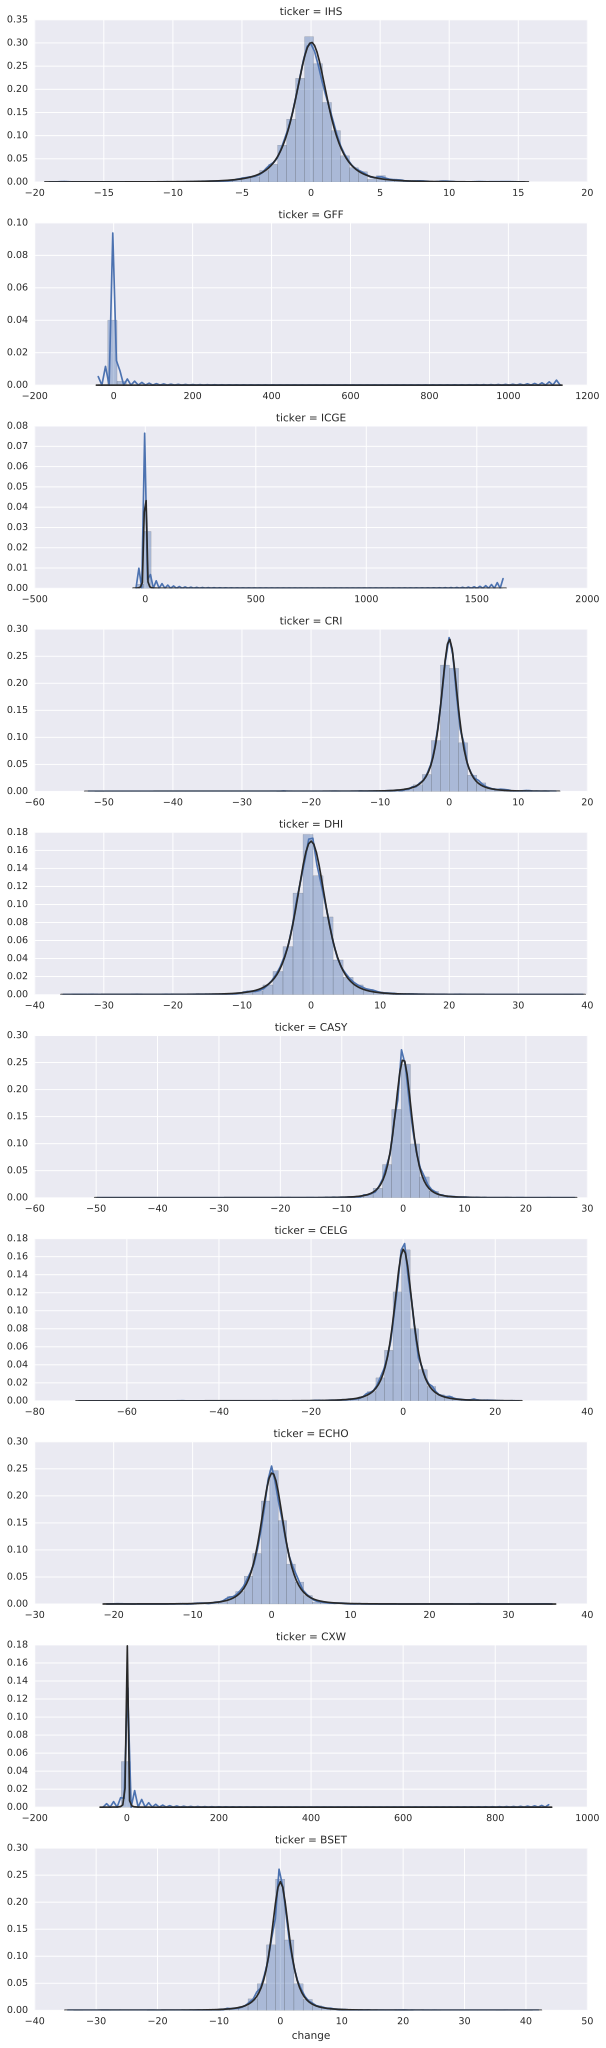

In [42]:
g2 = sns.FacetGrid(sampled_returns, row="ticker", sharex=False, sharey=False, aspect=3)
_ = g2.map(sns.distplot, "change", fit=stats.t)